Import

In [13]:
!pip install matplotlib seaborn plotly
!pip install transformers
!pip install scikit-learn
!pip install transformers datasets
!pip install datasets
!pip install --upgrade datasets

In [14]:
import pandas as pd
import os
import zipfile
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3
from datasets import Dataset
from sklearn.model_selection import train_test_split
from sklearn.svm import OneClassSVM
from sklearn.metrics import classification_report, accuracy_score
from sklearn.decomposition import PCA
from transformers import AutoTokenizer, AutoModel
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from torch.utils.data import DataLoader, Dataset
from google.colab import files
import torch
from tqdm import tqdm
from sklearn.metrics import classification_report, accuracy_score
import logging
logging.basicConfig(level=logging.INFO)

ekstrak file

In [3]:
uploaded = files.upload()
zip_file_name = 'Full_Process_Traces 2.zip'
extract_folder_name = 'datasets'
with zipfile.ZipFile(zip_file_name, 'r') as zip_ref:
    zip_ref.extractall(extract_folder_name)
os.listdir(extract_folder_name)


Saving Full_Process_Traces 2.zip to Full_Process_Traces 2.zip


['Full_Trace_Attack_Data',
 'Full_Trace_Training_Data',
 'Full_Trace_Validation_Data',
 '.DS_Store']

untuk membaca data

In [15]:
def load_adfa_ids(dataset_dir):
    data = []
    for root, dirs, files in os.walk(dataset_dir):
        for file in files:

            try:
                with open(os.path.join(root, file), 'r', encoding='latin-1') as f:
                    sequence = f.readlines()
                    sequence = [line.strip() for line in sequence]
                    data.append(sequence)
            except UnicodeDecodeError:

                try:
                    with open(os.path.join(root, file), 'r', encoding='utf-16') as f:
                        sequence = f.readlines()
                        sequence = [line.strip() for line in sequence]
                        data.append(sequence)
                except UnicodeDecodeError:
                    print(f"Error reading file: {file}. Skipping...")
    return [' '.join(seq) for seq in data]

normal_data = load_adfa_ids('datasets/Full_Trace_Training_Data/')
attack_data = load_adfa_ids('datasets/Full_Trace_Attack_Data/')

combined_data = normal_data + attack_data

# Create a DataFrame with sequences only
df = pd.DataFrame({
    'sequence': combined_data
})

# Shuffle the DataFrame
df = df.sample(frac=1).reset_index(drop=True)

Display data


In [16]:
print(df.head(5))
print(df.info())

                                            sequence
0           kernel32.dll+0x1084d kernel32.dll+0xb50b
1  kernel32.dll+0xb50b kernel32.dll+0xb511 kernel...
2  kernel32.dll+0xb50b kernel32.dll+0xb50b kernel...
3  ntdll.dll+0x16d33 ntdll.dll+0x16f03 ntdll.dll+...
4  ntdll.dll+0x22d81 ntdll.dll+0x22d2d ntdll.dll+...
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5899 entries, 0 to 5898
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   sequence  5899 non-null   object
dtypes: object(1)
memory usage: 46.2+ KB
None


display data

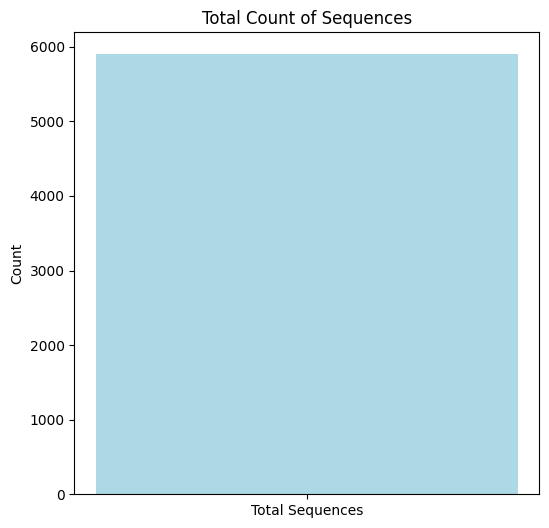

In [17]:
total_count = len(df)

# Create a simple bar plot
plt.figure(figsize=(6, 6))
plt.bar(['Total Sequences'], [total_count], color='lightblue')
plt.title('Total Count of Sequences')
plt.ylabel('Count')
plt.show()

sample dataframe

In [18]:
data = {
    'sequence': [['call1', 'call2', 'call3'], ['call4', 'call5']],
    'label': [0, 1]  # Example labels (0 for normal, 1 for attack)
}
df = pd.DataFrame(data)

# Print the DataFrame to verify
print(df)

                sequence  label
0  [call1, call2, call3]      0
1         [call4, call5]      1


Splitting data training dan testing

In [19]:
train_data, test_data = train_test_split(df, test_size=0.3, random_state=42)

# Optionally reset the indices of the train and test DataFrames
train_data.reset_index(drop=True, inplace=True)
test_data.reset_index(drop=True, inplace=True)

Proses tokenisasi

In [20]:
df['sequence'] = df['sequence'].apply(lambda x: ' '.join(x))


tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')


tokenized = tokenizer(
    df['sequence'].tolist(),
    padding='max_length',
    truncation=True,
    max_length=100,
    return_tensors='pt'
)


input_ids = tokenized['input_ids']
attention_mask = tokenized['attention_mask']


print("Input IDs:", input_ids)
print("Attention Mask:", attention_mask)

Input IDs: tensor([[ 101, 2655, 2487, 2655, 2475, 2655, 2509,  102,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0],
        [ 101, 2655, 2549, 2655, 2629,  102,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,  

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [21]:
from transformers import BertModel
model = BertModel.from_pretrained('bert-base-uncased')
model.eval()  # Set the model to evaluation mode

# Get embeddings
with torch.no_grad():  # No need to track gradients
    outputs = model(input_ids, attention_mask=attention_mask)
    embeddings = outputs.last_hidden_state  # Shape: (batch_size, sequence_length, hidden_size)
    pooled_embeddings = torch.mean(embeddings, dim=1)


print("Pooled Embeddings:", pooled_embeddings)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Pooled Embeddings: tensor([[-0.2495, -0.4530,  0.4182,  ..., -0.1992, -0.0654, -0.2436],
        [-0.2032, -0.4982,  0.4483,  ..., -0.3751, -0.2151, -0.2043]])


In [22]:
conn = sqlite3.connect('embeddings.db')

# Save embeddings to a table
embeddings_df = pd.DataFrame(pooled_embeddings)
embeddings_df.to_sql('embeddings', conn, if_exists='replace', index=False)

conn.close()

Data baru untuk pendeteksian anomali

In [24]:
X = pooled_embeddings.numpy()

# Create One-Class SVM model
oc_svm = OneClassSVM(kernel='rbf', gamma='auto', nu=0.1)

# Fit model on normal data
oc_svm.fit(X)

new_raw_data = test_data
new_tokenized = tokenizer(
    new_raw_data['sequence'].tolist(),
    padding='max_length',
    truncation=True,
    max_length=100,
    return_tensors='pt'
)
new_input_ids = new_tokenized['input_ids']
new_attention_mask = new_tokenized['attention_mask']
with torch.no_grad():
    new_outputs = model(new_input_ids, attention_mask=new_attention_mask)
    new_embeddings = new_outputs.last_hidden_state
    new_pooled_embeddings = torch.mean(new_embeddings, dim=1)

# Predict on new data
new_data = new_pooled_embeddings.numpy() # Your new dataset here

Analisa Anomali

In [25]:
predictions = oc_svm.predict(new_data)

# Identify anomalies
anomalies = predictions == -1
print("Anomalous Data Points Indices:", np.where(anomalies)[0])

Anomalous Data Points Indices: [0]


Analisa hasil

In [26]:
anomaly_indices = np.where(anomalies)[0]

# Output the anomalous data points
anomalous_data = new_data[anomaly_indices]
print("Anomalous Data Points:")
print(anomalous_data)

Anomalous Data Points:
[[-3.70103121e-01 -5.13417423e-01  2.94809073e-01 -3.62239838e-01
   8.99516568e-02  2.66093642e-01  5.10846078e-01  2.18529969e-01
   1.95331991e-01 -2.73345619e-01 -2.15451971e-01  2.58437753e-01
  -3.23797107e-01  1.71084017e-01 -8.23399350e-02 -3.17856520e-01
  -2.01781794e-01  3.11679661e-01  6.98460340e-01 -1.66134790e-01
   1.47307873e-01  6.67229593e-02 -1.08061381e-01 -4.05189544e-01
   4.47464377e-01  4.23056364e-01 -7.91707277e-01 -1.85818136e-01
  -3.24284136e-01  4.14105117e-01 -2.27863327e-01 -7.13389575e-01
   2.00690866e-01  1.56885520e-01 -1.79673851e-01 -2.71441162e-01
  -1.72591135e-02 -2.54574805e-01 -3.33605200e-01  1.40680512e-02
  -4.79174614e-01 -7.99880266e-01  1.58293158e-01 -1.80358142e-01
   1.02793224e-01  5.06073177e-01 -3.43841940e-01  2.16191173e-01
  -2.15396017e-01 -2.34341025e-02 -7.36011863e-01  2.60150999e-01
   6.58802092e-02  2.21520558e-01  1.57965243e-01 -2.05608234e-01
   3.99103701e-01 -1.90665364e-01 -6.31502569e-02 -5.

Evaluasi performa hasil

In [27]:
num_normal = len(new_raw_data) // 2  # Assuming first half is normal
num_anomalous = len(new_raw_data) - num_normal

true_labels = [1] * num_normal + [0] * num_anomalous

# Convert -1 and 1 predictions to 0 and 1 for compatibility
predicted_labels = (predictions + 1) // 2  # Convert -1 to 0 and 1 to 1

In [29]:
from sklearn.metrics import precision_score, recall_score, f1_score
# Calculate metrics
accuracy = accuracy_score(true_labels, predicted_labels)
precision = precision_score(true_labels, predicted_labels)
recall = recall_score(true_labels, predicted_labels)
f1 = f1_score(true_labels, predicted_labels)

# Print the results
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

# Print detailed classification report
print(classification_report(true_labels, predicted_labels))

Accuracy: 1.00
Precision: 0.00
Recall: 0.00
F1 Score: 0.00
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         1

    accuracy                           1.00         1
   macro avg       1.00      1.00      1.00         1
weighted avg       1.00      1.00      1.00         1



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


gambar hasil

(1, 768)


/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_pca.py:591: RuntimeWarning: invalid value encountered in divide
  explained_variance_ = (S**2) / (n_samples - 1)


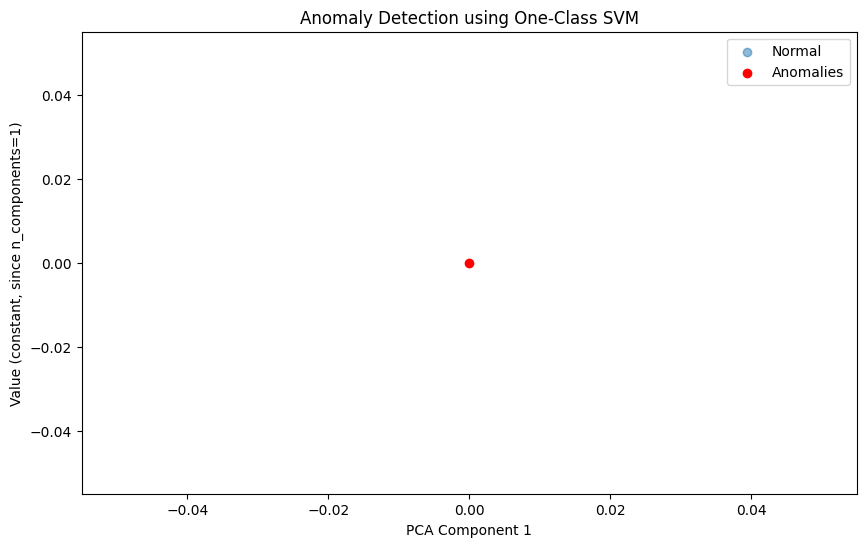

In [34]:
from sklearn.decomposition import PCA
print(new_data.shape)  # This will output (n_samples, n_features)

# Apply PCA
pca = PCA(n_components=1)
reduced_data = pca.fit_transform(new_data)

# Plot
plt.figure(figsize=(10, 6))

# Scatter plot for normal data (only one component)
plt.scatter(reduced_data[~anomalies, 0], [0] * len(reduced_data[~anomalies]), label='Normal', alpha=0.5)

# Scatter plot for anomaly data (only one component)
plt.scatter(reduced_data[anomalies, 0], [0] * len(reduced_data[anomalies]), label='Anomalies', color='red')

plt.legend()
plt.title('Anomaly Detection using One-Class SVM')
plt.xlabel('PCA Component 1')
plt.ylabel('Value (constant, since n_components=1)')
plt.show()